In [103]:
import zipfile
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2 as cv
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
import matplotlib.pyplot as plt
from cv2 import CascadeClassifier
from tensorflow.keras import applications
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint

Dataset creato da immagini di 3 attori diversi e organizzato in sottocartelle per ogni classe


In [4]:
zip = zipfile.ZipFile('/Actors.zip')
zip.extractall()
zip.close()

## Data augmentation del dataset originale


Operations performed: rotation, flip, brightness

In [5]:
def data_aug():
#for each folder in actors directory perform data augmentation
    #data generator
    datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest', horizontal_flip=True, brightness_range=[0.5,1.5])
    iterator = datagen.flow_from_directory("./Actors", color_mode="rgb", batch_size=1, class_mode="categorical")

    for f in sorted(os.listdir('./Actors/Bradley')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Bradley/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Bradley/' + f + "_" + str(i) + ".jpg", image)

    for f in sorted(os.listdir('./Actors/Leonardo')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Leonardo/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Leonardo/' + f + "_" + str(i) + ".jpg", image)

    for f in sorted(os.listdir('./Actors/Toretto')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Toretto/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Toretto/' + f + "_" + str(i) + ".jpg", image)


Final dataset records: 65 x 10 = 650

In [6]:
data_aug()

Found 65 images belonging to 3 classes.


Example of data augmentation

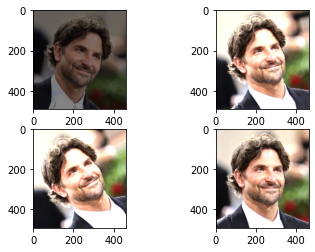

In [7]:
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
plt.subplot(2,2,1)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_1.jpg")))
plt.subplot(2,2,2)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_2.jpg")))
plt.subplot(2,2,3)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_3.jpg")))
plt.subplot(2,2,4)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_4.jpg")))

## Data loader + face detection

In [8]:
def face_detection(img):
    # funzione che data un'immagine ritorna solamente il crop della faccia che trova al suo interno
    classifier = CascadeClassifier('/haarcascade_frontalface_default.xml')
    box = classifier.detectMultiScale(img)
    #se non trova nessuna faccia non ritorna niente
    (x,y,w,h) = (0,0,0,0)
    if box is ():
        return None
    #altrimenti ritorna solo la prima faccia
    else:
        (x,y,w,h) = box[0]
        return cv.resize(img[y:y+h, x:x+w, :], (224,224))

In [9]:
def load_data():
    # funzione che per con le immagini crea il dataset di train e test applicando prima la funzione di face detection
    labels = []
    images = []

    for f in sorted(os.listdir('./Actors/Bradley')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Bradley/' + f)
            img = (face_detection(img))
            #se il face detector trova un'immagine allora la aggiunge al dataset
            if img is not None:
                images.append(img)
                # lable
                labels.append("Bradley")

    for f in sorted(os.listdir('./Actors/Leonardo')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Leonardo/' + f)
            img = (face_detection(img))
            if img is not None:
                images.append(img)
                # lable
                labels.append("Leonardo")

    for f in sorted(os.listdir('./Actors/Toretto')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Toretto/' + f)
            img = (face_detection(img))
            if img is not None:
                images.append(img)
                # lable
                labels.append("Toretto")

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=1)
    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = load_data()

Lables to categorical

In [49]:
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

Esempio di face detection

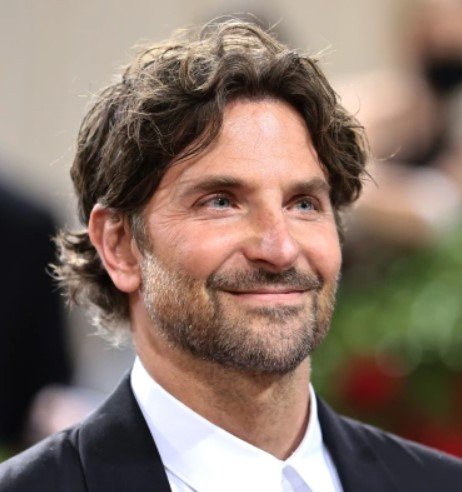

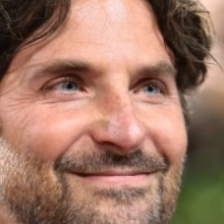

In [50]:
from google.colab.patches import cv2_imshow
img = cv.imread("/content/Actors/Bradley/19.jpg")
cv2_imshow(img)
img = face_detection(img)
cv2_imshow(img)

# CNN training with transporter NN

Utilizzo come base la NN EfficientNetB7

In [12]:
base_net = applications.EfficientNetB7(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

258088960/258076736 [==============================] - 1s 0us/step


In [51]:
#Non alleno i layer importati dalla rete
for layer in base_net.layers:
    layer.trainable = False

Crezione architettura e aggiunta ulteriore Data augmentation

In [97]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
# Data augmentation
#x = keras.layers.RandomFlip(mode = "horizontal")
#x = keras.layers.RandomContrast(factor=(0.9, 1.1))

# preprocessing dell'immagine ottimizzata per efficientnet
x = applications.efficientnet.preprocess_input(x)
x = base_net(x)
x = keras.layers.Dense(1024, activation='relu')(x)

outputs = keras.layers.Dense(3, activation='softmax')(x)

In [98]:
net = keras.Model(inputs=inputs, outputs=outputs)

Fase training

In [99]:
net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [100]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [101]:
checkpoint = ModelCheckpoint("./models", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = net.fit(x=X_train, y=y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks_list);

Epoch 1/25
13/13 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.6112
Epoch 1: val_accuracy improved from -inf to 0.78641, saving model to ./models
INFO:tensorflow:Assets written to: ./models/assets
13/13 [==============================] - 218s 16s/step - loss: 1.4564 - accuracy: 0.6112 - val_loss: 0.5646 - val_accuracy: 0.7864
Epoch 2/25
13/13 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8484
Epoch 2: val_accuracy improved from 0.78641 to 0.90291, saving model to ./models
INFO:tensorflow:Assets written to: ./models/assets
13/13 [==============================] - 174s 14s/step - loss: 0.3722 - accuracy: 0.8484 - val_loss: 0.3857 - val_accuracy: 0.9029
Epoch 3/25
13/13 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8484
Epoch 3: val_accuracy did not improve from 0.90291
13/13 [==============================] - 6s 486ms/step - loss: 0.3798 - accuracy: 0.8484 - val_loss: 1.0231 - val_accuracy: 0.6796
Epoch 4/25
13

## Evaluation

In [102]:
net.evaluate(X_test, y_test)

2/2 [==============================] - 1s 286ms/step - loss: 0.0030 - accuracy: 1.0000


[0.0029691855888813734, 1.0]

# Feature explanation with Grad_CAM


In [124]:
from scipy.ndimage import zoom
img = cv.imread("/content/Actors/Bradley/1.jpg")
img = face_detection(img)
img = np.expand_dims(img, axis=0).astype(np.float32)
img = applications.efficientnet.preprocess_input(img)

preds = net.predict(img)
print(preds)

[[9.9991524e-01 7.9503123e-05 5.2213386e-06]]


In [111]:
net.get_layer('efficientnetb7').summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0